In [1]:
suppressMessages(suppressWarnings(library(dplyr)))
suppressMessages(suppressWarnings(library(reshape2)))
suppressMessages(suppressWarnings(library(stringr)))
suppressMessages(suppressWarnings(library(anytime)))
suppressMessages(suppressWarnings(library(tidyverse)))
suppressMessages(suppressWarnings(library(plotly)))
options(repr.plot.width=16, repr.plot.height=7)
options(scipen = 999) # Disabling scientific notation

# Final Project: Predict Future Sales

https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data

Goals

1. We are not competing with other teams on kaggle
2. This project is a playground to practice the knowledge of this class and prepare for the final exam.
3. Group project, 1-4 people per team
4. You can use R or Python
5. Use dataframe to process data
6. Build one prediction model using the ML algorithms of this course
7. Evaluate your prediction model
8. Try different ways to improve your model and show the improvements.
9. Submit code and results in Jupyter and HTML formats on canvas

## Challenge

This challenge serves as final project for the "How to win a data science competition" Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

## File descriptions

* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.


## Data fields

* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

First step is to load the train dataset and do an initial analysis on how it looks like

In [2]:
sales_train = read.csv("sales_train.csv")
nrow(sales_train)
head(sales_train)

[1] 2935849

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
1,02.01.2013,0,59,22154,999.00,1
2,03.01.2013,0,25,2552,899.00,1
3,05.01.2013,0,25,2552,899.00,-1
4,06.01.2013,0,25,2554,1709.05,1
5,15.01.2013,0,25,2555,1099.00,1
6,10.01.2013,0,25,2564,349.00,1


Let's see how the test set looks like:

In [3]:
sales_test = read.csv("test.csv")
nrow(sales_test)
head(sales_test)

[1] 214200

,ID,shop_id,item_id
,<int>,<int>,<int>
1,0,5,5037
2,1,5,5320
3,2,5,5233
4,3,5,5232
5,4,5,5268
6,5,5,5039


We have less information on test set than we have on train. Let's check how the "domain" tables (shops.csv and items.csv) look like. Let's start with shop:

In [4]:
shops = read.csv("shops.csv")
head(shops)

,shop_name,shop_id
,<chr>,<int>
1,"!Ð¯ÐºÑƒÑ‚ÑÐº ÐžÑ€Ð´Ð¶Ð¾Ð½Ð¸ÐºÐ¸Ð´Ð·Ðµ, 56 Ñ„Ñ€Ð°Ð½",0
2,"!Ð¯ÐºÑƒÑ‚ÑÐº Ð¢Ð¦ ""Ð¦ÐµÐ½Ñ‚Ñ€Ð°Ð»ÑŒÐ½Ñ‹Ð¹"" Ñ„Ñ€Ð°Ð½",1
3,"ÐÐ´Ñ‹Ð³ÐµÑ Ð¢Ð¦ ""ÐœÐµÐ³Ð°""",2
4,"Ð‘Ð°Ð»Ð°ÑˆÐ¸Ñ…Ð° Ð¢Ð Ðš ""ÐžÐºÑ‚ÑÐ±Ñ€ÑŒ-ÐšÐ¸Ð½Ð¾Ð¼Ð¸Ñ€""",3
5,"Ð’Ð¾Ð»Ð¶ÑÐºÐ¸Ð¹ Ð¢Ð¦ ""Ð’Ð¾Ð»Ð³Ð° ÐœÐ¾Ð»Ð»""",4
6,"Ð’Ð¾Ð»Ð¾Ð³Ð´Ð° Ð¢Ð Ð¦ ""ÐœÐ°Ñ€Ð¼ÐµÐ»Ð°Ð´""",5


Not much information from it, as we already have a shop id, which reflects the different categories for this feature, we do not need to worry about the shop name, so, we won't be using this table. Let's now check items.csv:

In [5]:
items = read.csv("items.csv")
head(items)

,item_name,item_id,item_category_id
,<chr>,<int>,<int>
1,! Ð’Ðž Ð’Ð›ÐÐ¡Ð¢Ð˜ ÐÐÐ’ÐÐ–Ð”Ð•ÐÐ˜Ð¯ (ÐŸÐ›ÐÐ¡Ð¢.) D,0,40
2,"!ABBYY FineReader 12 Professional Edition Full [PC, Ð¦Ð¸Ñ„Ñ€Ð¾Ð²Ð°Ñ Ð²ÐµÑ€ÑÐ¸Ñ]",1,76
3,***Ð’ Ð›Ð£Ð§ÐÐ¥ Ð¡Ð›ÐÐ’Ð« (UNV) D,2,40
4,***Ð“ÐžÐ›Ð£Ð‘ÐÐ¯ Ð’ÐžÐ›ÐÐ (Univ) D,3,40
5,***ÐšÐžÐ ÐžÐ‘ÐšÐ (Ð¡Ð¢Ð•ÐšÐ›Ðž) D,4,40
6,***ÐÐžÐ’Ð«Ð• ÐÐœÐ•Ð Ð˜ÐšÐÐÐ¡ÐšÐ˜Ð• Ð“Ð ÐÐ¤Ð¤Ð˜Ð¢Ð˜ (UNI) D,5,40


We have one additional information that may be useful, which is item_category_id. Let's just make sure we don't have duplicities on this table:

In [6]:
items %>% count(item_id) %>% arrange(desc(n)) %>% filter(n > 1)

item_id,n
<int>,<int>


We don't have duplicities, so, we can use it to enhance our train set (and later our test set) with item_category_id: 

In [7]:
nrow(sales_train)
sales_train_enhanced = sales_train %>%
    inner_join(items, by = "item_id") %>%
    select(date_block_num, shop_id, item_id, item_category_id, item_price, item_cnt_day)
nrow(sales_train_enhanced)
head(sales_train_enhanced)

[1] 2935849

[1] 2935849

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_day
,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,0,59,22154,37,999.00,1
2,0,25,2552,58,899.00,1
3,0,25,2552,58,899.00,-1
4,0,25,2554,58,1709.05,1
5,0,25,2555,56,1099.00,1
6,0,25,2564,59,349.00,1


We can see above that we had exactly matches when joining and we didn't miss any product or sale. As stated on the challenge, that we should predict the product sales for the next month, we are going to group the sales per store, item and month (using date_block_num). 

But before that we are going to generate another column named total_price, which is the multiplication of item_price per item_cnt_day (it probably won't be used, but let's add anyway)

Let's start with adding the new column "total_price":

In [8]:
sales_train_enhanced = sales_train_enhanced %>%
    mutate(total_price = item_price * item_cnt_day)
head(sales_train_enhanced)

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_day,total_price
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,0,59,22154,37,999.00,1,999.00
2,0,25,2552,58,899.00,1,899.00
3,0,25,2552,58,899.00,-1,-899.00
4,0,25,2554,58,1709.05,1,1709.05
5,0,25,2555,56,1099.00,1,1099.00
6,0,25,2564,59,349.00,1,349.00


Now, let's summarize the sales at month level:

In [9]:
sales_train_enhanced = sales_train_enhanced %>%
    group_by(date_block_num, shop_id, item_id, item_category_id) %>%
    summarize(
        item_cnt_month = sum(item_cnt_day), 
        total_price = sum(total_price))
head(sales_train_enhanced)

`summarise()` has grouped output by 'date_block_num', 'shop_id', 'item_id'. You can override using the `.groups`
argument.


date_block_num,shop_id,item_id,item_category_id,item_cnt_month,total_price
<int>,<int>,<int>,<int>,<dbl>,<dbl>
0,0,32,40,6,1326
0,0,33,37,3,1041
0,0,35,40,1,247
0,0,43,40,1,221
0,0,51,57,2,257
0,0,61,43,1,195


As we the goal is to predict a continuous value, we will start working with Linear Regression model. As shop_id, item_id and item_category_id are categorical features, and not really numeric ones, the rule of thumb would be "encode" them as numeric columns indicating if that feature is available or not for the case (one hot encoding). 

But before that, let's "play" with regression using those features as they are (as if they were numeric variables)

## 1st attempt: simple linear regression model using categorical variables as numeric

In [10]:
first_attempt = lm(item_cnt_month ~ date_block_num + shop_id + item_id + item_category_id, sales_train_enhanced)
summary(first_attempt)


Call:
lm(formula = item_cnt_month ~ date_block_num + shop_id + item_id + 
    item_category_id, data = sales_train_enhanced)

Residuals:
    Min      1Q  Median      3Q     Max 
 -24.09   -1.27   -1.16   -0.24 2250.46 

Coefficients:
                     Estimate   Std. Error t value             Pr(>|t|)    
(Intercept)       2.633243865  0.025758473 102.228 < 0.0000000000000002 ***
date_block_num    0.002405658  0.000714768   3.366             0.000764 ***
shop_id           0.000379968  0.000412574   0.921             0.357066    
item_id          -0.000009407  0.000001144  -8.220 < 0.0000000000000002 ***
item_category_id -0.007542083  0.000437428 -17.242 < 0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 8.649 on 1609119 degrees of freedom
Multiple R-squared:  0.000312,	Adjusted R-squared:  0.0003095 
F-statistic: 125.5 on 4 and 1609119 DF,  p-value: < 0.00000000000000022


Before using the trained model to predict our test dataset, we need to apply the same transformations we have applied to our train set. Mainly we will need to add date_block_num (the next month, thus, the max of date_block_num + 1) and add the item_category_id.

In [11]:
sales_test_1st_attempt = sales_test
sales_test_1st_attempt$date_block_num = max(sales_train_enhanced$date_block_num) + 1
sales_test_1st_attempt = sales_test_1st_attempt %>%
    inner_join(items, by = "item_id") %>%
    select(ID, date_block_num, shop_id, item_id, item_category_id)
head(sales_test_1st_attempt)

,ID,date_block_num,shop_id,item_id,item_category_id
,<int>,<dbl>,<int>,<int>,<int>
1,0,34,5,5037,19
2,1,34,5,5320,55
3,2,34,5,5233,19
4,3,34,5,5232,23
5,4,34,5,5268,20
6,5,34,5,5039,23


Now let's predict using the linear regression model generated

In [12]:
sales_test_1st_attempt = cbind(sales_test_1st_attempt, 
                               predict(first_attempt, sales_test_1st_attempt))
colnames(sales_test_1st_attempt) = c("ID", "date_block_num", "shop_id", "item_id", "item_category_id", "item_cnt_month")
head(sales_test_1st_attempt)

,ID,date_block_num,shop_id,item_id,item_category_id,item_cnt_month
,<int>,<dbl>,<int>,<int>,<int>,<dbl>
1,0,34,5,5037,19,2.526254
2,1,34,5,5320,55,2.252077
3,2,34,5,5233,19,2.524410
4,3,34,5,5232,23,2.494251
5,4,34,5,5268,20,2.516539
6,5,34,5,5039,23,2.496067


Now, we create the submission file

In [13]:
write.csv(sales_test_1st_attempt[, c("ID", "item_cnt_month")], "1st_attempt.csv", row.names = FALSE)

As expected, this way of doing regression was not that accurate. After submitting the score was 2.330 and put us around position 13500 our of 14600

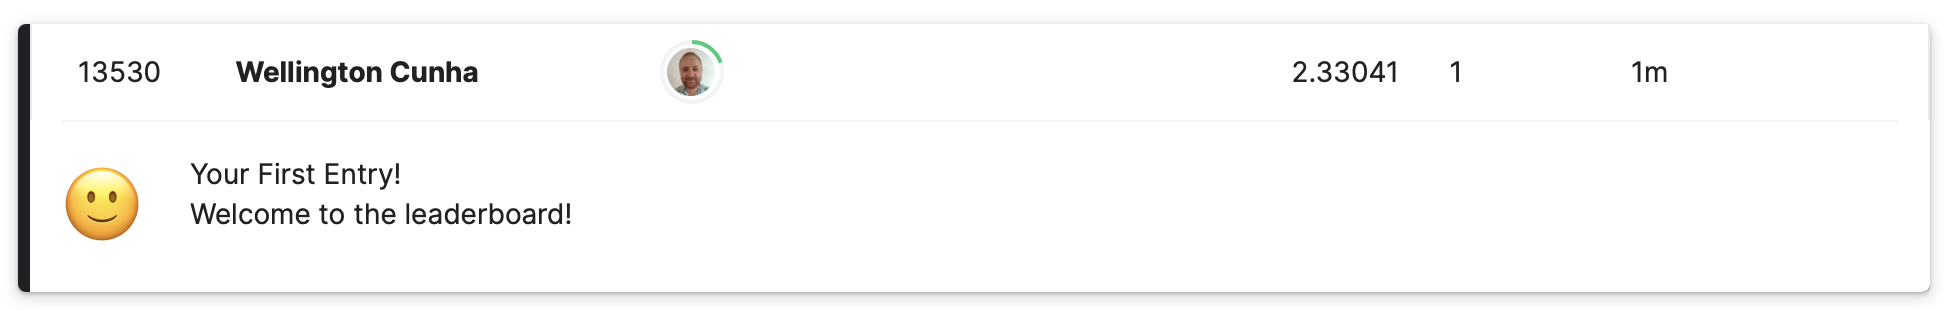

Let's now try to generate the prediction using XGBoost

## 2nd attempt: XGBoost regression

As XGBoost works with trees, we still don't need to encode our categorical variables. Let's start checking how it goes with basic setting and without twerking hyper-parameters. 

In [14]:
suppressMessages(suppressWarnings(require(xgboost)))

In [15]:
sales_train_enhanced_2nd_attempt = data.frame(
    sales_train_enhanced[, c("date_block_num", "shop_id", "item_id", "item_category_id", "item_cnt_month")])
train_x = data.matrix(sales_train_enhanced_2nd_attempt[, -5])
train_y = sales_train_enhanced_2nd_attempt[, 5]

xgb_train = xgb.DMatrix(data = train_x, label = train_y)
xgbc = xgboost(data = xgb_train, max.depth = 1, nrounds = 25, verbose = 0)
print(xgbc)

##### xgb.Booster
raw: 22.5 Kb 
call:
  xgb.train(params = params, data = dtrain, nrounds = nrounds, 
    watchlist = watchlist, verbose = verbose, print_every_n = print_every_n, 
    early_stopping_rounds = early_stopping_rounds, maximize = maximize, 
    save_period = save_period, save_name = save_name, xgb_model = xgb_model, 
    callbacks = callbacks, max.depth = 1)
params (as set within xgb.train):
  max_depth = "1", validate_parameters = "1"
xgb.attributes:
  niter
callbacks:
  cb.evaluation.log()
# of features: 4 
niter: 25
nfeatures : 4 
evaluation_log:
    iter train_rmse
       1   8.725652
       2   8.671492
---                
      24   8.545318
      25   8.542213


Now we prepare our test set, predict it and generate the file for submission

In [16]:
sales_test_2nd_attempt = sales_test
sales_test_2nd_attempt$date_block_num = max(sales_train_enhanced$date_block_num) + 1
sales_test_2nd_attempt = sales_test_2nd_attempt %>%
    inner_join(items, by = "item_id") %>%
    select(ID, date_block_num, shop_id, item_id, item_category_id)
head(sales_test_2nd_attempt)

,ID,date_block_num,shop_id,item_id,item_category_id
,<int>,<dbl>,<int>,<int>,<int>
1,0,34,5,5037,19
2,1,34,5,5320,55
3,2,34,5,5233,19
4,3,34,5,5232,23
5,4,34,5,5268,20
6,5,34,5,5039,23


In [17]:
test_x = data.matrix(sales_test_2nd_attempt[, -1])
xgb_test = xgb.DMatrix(data = test_x)
pred_y = predict(xgbc, xgb_test)

In [18]:
sales_test_2nd_attempt = cbind(sales_test_2nd_attempt, 
                               pred_y)
colnames(sales_test_2nd_attempt) = c("ID", "date_block_num", "shop_id", "item_id", "item_category_id", "item_cnt_month")
head(sales_test_2nd_attempt)

,ID,date_block_num,shop_id,item_id,item_category_id,item_cnt_month
,<int>,<dbl>,<int>,<int>,<int>,<dbl>
1,0,34,5,5037,19,2.721828
2,1,34,5,5320,55,1.860077
3,2,34,5,5233,19,2.721828
4,3,34,5,5232,23,2.721828
5,4,34,5,5268,20,2.721828
6,5,34,5,5039,23,2.721828


In [19]:
write.csv(sales_test_2nd_attempt[, c("ID", "item_cnt_month")], "2nd_attempt.csv", row.names = FALSE)

We could improve a little bit our score with the second attempt using XGBoost, but not much and we are still around position 13500 of the ranking:

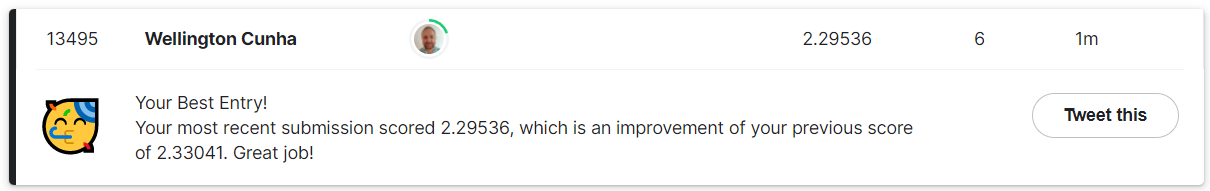

As stated on the challenge "...the list of shops and products slightly changes every month.". The fact that we do not have data for some months for given shop and item can create biasis when generating our linear regression. So, we are going to fill for every month with sales for every shop and item we need to predict, using 0 for items sold and price.

## 3rd attempt: simple linear regression + dummy sales

In [20]:
dummy = expand.grid(unique(sales_train_enhanced$date_block_num), 
                    unique(sales_test$shop_id), 
                    unique(sales_test$item_id))
colnames(dummy) = c("date_block_num", "shop_id", "item_id")
dummy = dummy %>%
    inner_join(items, by = "item_id") %>%
    select(date_block_num, shop_id, item_id, item_category_id)
nrow(dummy)
dummy = dummy %>%
    full_join(sales_train_enhanced, by = c("date_block_num", "shop_id", "item_id", "item_category_id")) %>%
    mutate(
        item_cnt_month = ifelse(is.na(item_cnt_month), 0, item_cnt_month),
        total_price = ifelse(is.na(total_price), 0, total_price)) #%>%
nrow(dummy)
sales_train_enhanced = dummy

[1] 7282800

[1] 8291765

In [21]:
sales_train_enhanced_3rd_attempt = sales_train_enhanced
model_3rd_attempt = lm(item_cnt_month ~ date_block_num + shop_id + item_id + item_category_id, 
                       sales_train_enhanced_3rd_attempt)
summary(model_3rd_attempt)


Call:
lm(formula = item_cnt_month ~ date_block_num + shop_id + item_id + 
    item_category_id, data = sales_train_enhanced_3rd_attempt)

Residuals:
    Min      1Q  Median      3Q     Max 
 -22.28   -0.51   -0.38   -0.22 2252.38 

Coefficients:
                      Estimate    Std. Error t value             Pr(>|t|)    
(Intercept)       0.8492665979  0.0053458970  158.86 < 0.0000000000000002 ***
date_block_num   -0.0049043371  0.0001390682  -35.27 < 0.0000000000000002 ***
shop_id           0.0014293050  0.0000779761   18.33 < 0.0000000000000002 ***
item_id          -0.0000012348  0.0000002253   -5.48         0.0000000425 ***
item_category_id -0.0079564944  0.0000845864  -94.06 < 0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.912 on 8291760 degrees of freedom
Multiple R-squared:  0.001391,	Adjusted R-squared:  0.001391 
F-statistic:  2888 on 4 and 8291760 DF,  p-value: < 0.00000000000000022


Now we prepare our test dataset, predict and submit to see what we get

In [22]:
sales_test_3rd_attempt = sales_test
sales_test_3rd_attempt$date_block_num = max(sales_train_enhanced$date_block_num) + 1
sales_test_3rd_attempt = sales_test_3rd_attempt %>%
    inner_join(items, by = "item_id") %>%
    select(ID, date_block_num, shop_id, item_id, item_category_id)
head(sales_test_3rd_attempt)

,ID,date_block_num,shop_id,item_id,item_category_id
,<int>,<dbl>,<int>,<int>,<int>
1,0,34,5,5037,19
2,1,34,5,5320,55
3,2,34,5,5233,19
4,3,34,5,5232,23
5,4,34,5,5268,20
6,5,34,5,5039,23


In [23]:
sales_test_3rd_attempt = cbind(sales_test_3rd_attempt, 
                               predict(model_3rd_attempt, sales_test_3rd_attempt))
colnames(sales_test_3rd_attempt) = c("ID", "date_block_num", "shop_id", "item_id", 
                                     "item_category_id", "item_cnt_month")
head(sales_test_3rd_attempt)

,ID,date_block_num,shop_id,item_id,item_category_id,item_cnt_month
,<int>,<dbl>,<int>,<int>,<int>,<dbl>
1,0,34,5,5037,19,0.5322727
2,1,34,5,5320,55,0.2454895
3,2,34,5,5233,19,0.5320307
4,3,34,5,5232,23,0.5002059
5,4,34,5,5268,20,0.5240310
6,5,34,5,5039,23,0.5004443


In [24]:
write.csv(sales_test_3rd_attempt[, c("ID", "item_cnt_month")], "3rd_attempt.csv", row.names = FALSE)

Wow! Just by adding the missing "sales" make our score increase from 2.295 to 1.214, which pumped us up to position around 9600

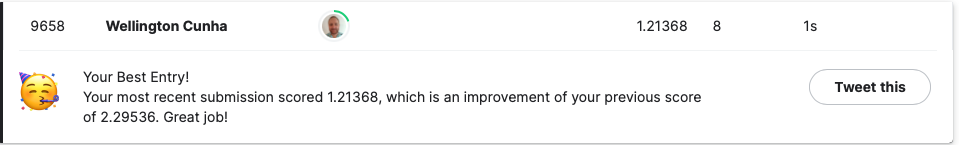

## 4th attempt: adding 1 to date_block_num

We know (from Linear Regression class) that predictors with too much zero values can generate biases when estimating the predictors. So, we are going to add 1 to the predictor variable that contains the month sequence, just to remove this potential bias. We are also going to remove item_category_id from the predictor set.

In [25]:
sales_train_enhanced$date_block_num = sales_train_enhanced$date_block_num + 1
head(sales_train_enhanced)

,date_block_num,shop_id,item_id,item_category_id,item_cnt_month,total_price
,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>
1,1,5,5037,19,0,0
2,2,5,5037,19,0,0
3,3,5,5037,19,0,0
4,4,5,5037,19,0,0
5,5,5,5037,19,0,0
6,6,5,5037,19,0,0


In [26]:
sales_train_enhanced_4th_attempt = sales_train_enhanced
model_4th_attempt = lm(item_cnt_month ~ date_block_num + shop_id + item_id, 
                       sales_train_enhanced_4th_attempt)
summary(model_4th_attempt)


Call:
lm(formula = item_cnt_month ~ date_block_num + shop_id + item_id, 
    data = sales_train_enhanced_4th_attempt)

Residuals:
    Min      1Q  Median      3Q     Max 
 -22.46   -0.48   -0.41   -0.33 2252.68 

Coefficients:
                    Estimate    Std. Error t value            Pr(>|t|)    
(Intercept)     0.5565550189  0.0043819507  127.01 <0.0000000000000002 ***
date_block_num -0.0051589734  0.0001391160  -37.08 <0.0000000000000002 ***
shop_id         0.0014356023  0.0000780177   18.40 <0.0000000000000002 ***
item_id        -0.0000068204  0.0000002175  -31.36 <0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.914 on 8291761 degrees of freedom
Multiple R-squared:  0.0003258,	Adjusted R-squared:  0.0003254 
F-statistic: 900.7 on 3 and 8291761 DF,  p-value: < 0.00000000000000022


Then again we prepare our test dataset, predict and submit to see what we get

In [27]:
sales_test_4th_attempt = sales_test
sales_test_4th_attempt$date_block_num = max(sales_train_enhanced$date_block_num) + 1
sales_test_4th_attempt = sales_test_4th_attempt %>%
    inner_join(items, by = "item_id") %>%
    select(ID, date_block_num, shop_id, item_id)
head(sales_test_4th_attempt)

,ID,date_block_num,shop_id,item_id
,<int>,<dbl>,<int>,<int>
1,0,35,5,5037
2,1,35,5,5320
3,2,35,5,5233
4,3,35,5,5232
5,4,35,5,5268
6,5,35,5,5039


In [28]:
sales_test_4th_attempt = cbind(sales_test_4th_attempt, 
                               predict(model_4th_attempt, sales_test_4th_attempt))
colnames(sales_test_4th_attempt) = c("ID", "date_block_num", "shop_id", "item_id", "item_cnt_month")
head(sales_test_4th_attempt)

,ID,date_block_num,shop_id,item_id,item_cnt_month
,<int>,<dbl>,<int>,<int>,<dbl>
1,0,35,5,5037,0.3488148
2,1,35,5,5320,0.3468847
3,2,35,5,5233,0.3474781
4,3,35,5,5232,0.3474849
5,4,35,5,5268,0.3472393
6,5,35,5,5039,0.3488012


In [29]:
write.csv(sales_test_4th_attempt[, c("ID", "item_cnt_month")], "4th_attempt.csv", row.names = FALSE)

The applied changes did not enhance the score:

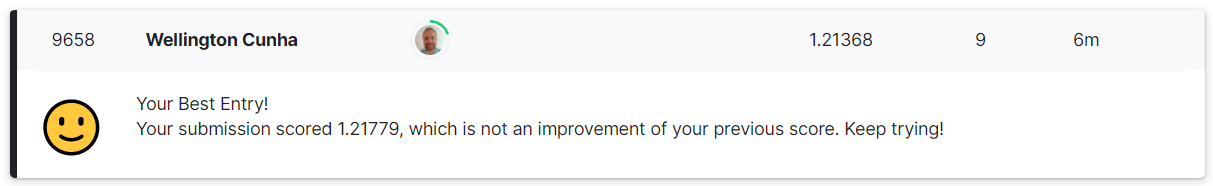

Let's try again with XGBoost after we have added the dummy sales for missing months

## 5th attempt: XGBoost after feature enhancement

In [30]:
sales_train_enhanced_5th_attempt = data.frame(
    sales_train_enhanced[, c("date_block_num", "shop_id", "item_id", "item_category_id", "item_cnt_month")])
train_x = data.matrix(sales_train_enhanced_5th_attempt[, -5])
train_y = sales_train_enhanced_5th_attempt[, 5]

xgb_train = xgb.DMatrix(data = train_x, label = train_y)
xgbc = xgboost(data = xgb_train, max.depth = 1, nrounds = 25, verbose = 0)
print(xgbc)

##### xgb.Booster
raw: 21.5 Kb 
call:
  xgb.train(params = params, data = dtrain, nrounds = nrounds, 
    watchlist = watchlist, verbose = verbose, print_every_n = print_every_n, 
    early_stopping_rounds = early_stopping_rounds, maximize = maximize, 
    save_period = save_period, save_name = save_name, xgb_model = xgb_model, 
    callbacks = callbacks, max.depth = 1)
params (as set within xgb.train):
  max_depth = "1", validate_parameters = "1"
xgb.attributes:
  niter
callbacks:
  cb.evaluation.log()
# of features: 4 
niter: 25
nfeatures : 4 
evaluation_log:
    iter train_rmse
       1   3.911308
       2   3.909487
---                
      24   3.899263
      25   3.899040


Now we prepare our training set, predict it and generate the file for submission

In [31]:
sales_test_5th_attempt = sales_test
sales_test_5th_attempt$date_block_num = max(sales_train_enhanced$date_block_num) + 1
sales_test_5th_attempt = sales_test_5th_attempt %>%
    inner_join(items, by = "item_id") %>%
    select(ID, date_block_num, shop_id, item_id, item_category_id)
head(sales_test_5th_attempt)

,ID,date_block_num,shop_id,item_id,item_category_id
,<int>,<dbl>,<int>,<int>,<int>
1,0,35,5,5037,19
2,1,35,5,5320,55
3,2,35,5,5233,19
4,3,35,5,5232,23
5,4,35,5,5268,20
6,5,35,5,5039,23


In [32]:
test_x = data.matrix(sales_test_5th_attempt[, -1])
xgb_test = xgb.DMatrix(data = test_x)
pred_y = predict(xgbc, xgb_test)

In [33]:
sales_test_5th_attempt = cbind(sales_test_5th_attempt, 
                               pred_y)
colnames(sales_test_5th_attempt) = c("ID", "date_block_num", "shop_id", "item_id", 
                                     "item_category_id", "item_cnt_month")
head(sales_test_5th_attempt)

,ID,date_block_num,shop_id,item_id,item_category_id,item_cnt_month
,<int>,<dbl>,<int>,<int>,<int>,<dbl>
1,0,35,5,5037,19,0.7006335
2,1,35,5,5320,55,0.2125038
3,2,35,5,5233,19,0.7006335
4,3,35,5,5232,23,0.7006335
5,4,35,5,5268,20,0.7006335
6,5,35,5,5039,23,0.7006335


In [34]:
write.csv(sales_test_5th_attempt[, c("ID", "item_cnt_month")], "5th_attempt.csv", row.names = FALSE)

The attempt using XGBoost enhanced our performance a little bit, moving us up around 100 positions on the ranking:

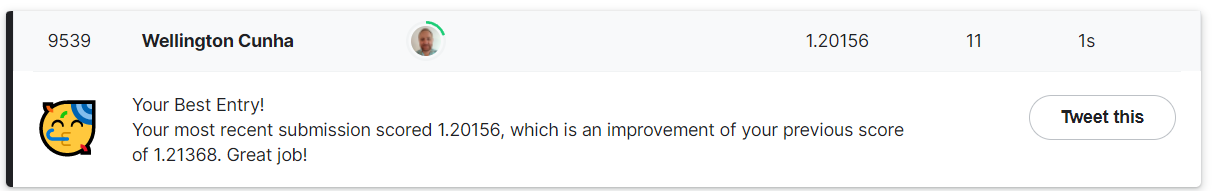

## Conclusion

Througout this project we have shown some of the most common steps when developing a machine learning model using R, such as:

* Data Analysis
* Data preparation (including feature engineering)
* Models training and evaluation

For sure we could have gone further, such as converting the categorical features on columns (one hot enconding) and/or experimented with XGBoost hyper-parameters. Or even try out other models (such as Random Forest). 

But for the purpose of the course, which is getting familiarized with Data Analysis using R, this is enough to show the content learned during the semester. 